# Ray Tutorial — DATS 6450
## Big Data & Cloud Computing

**Dataset**: NYC Yellow Taxi Trip Data (2022-2023 data stored at `s3://adg-teaching/dats/data/nyt-data/`)

**Environment**: Single-node t3.large EC2 (2 vCPUs, 8 GB RAM) with `LabInstanceProfile` IAM role attached

## What You Will Learn

| Section | Topic |
|---------|-------|
| 1 | Environment setup & imports |
| 2 | Ray initialization — local vs. cluster mode |
| 3 | **Ray Tasks** — parallel fare estimation |
| 4 | **Ray Actors** — stateful trip aggregation |
| 5 | **Ray Object Store** — zero-copy shared data |
| 6 | **Ray Data ETL** — NYC Taxi extract → transform → load |
| 7 | Performance: Ray vs. serial pandas |
| 8 | Multi-node cluster reference (shown, not executed) |
| 9 | Cleanup & summary |

### Course Progression

```
Multiprocessing → Dask → Spark → Ray
```

Ray differs from Spark in two key ways:
- **Stateful actors** — Spark has no equivalent (workers are stateless)
- **Async-first** — `.remote()` returns a future immediately; Spark blocks per stage
- **Fine-grained tasks** — Ray tasks can be milliseconds; Spark stages are coarser

### NYC Taxi Dataset

The 2022-2023 [NYC TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) is hosted publicly on AWS at `s3://adg-teaching/dats/data/nyt-data/`. Each Parquet file covers one month of yellow taxi trips (~3M rows, ~50 MB compressed). We use **January 2023** for the ETL demo and three months for the performance comparison.

---
## Section 1 — Environment Setup

In [ ]:
# Sync all dependencies declared in pyproject.toml
!uv sync

In [1]:
import ray
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.fs as pafs
import boto3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import io

print(f"Ray:      {ray.__version__}")
print(f"pandas:   {pd.__version__}")
print(f"PyArrow:  {pa.__version__}")
print(f"boto3:    {boto3.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

Ray:      2.54.0
pandas:   2.3.0
PyArrow:  23.0.1
boto3:    1.42.49
matplotlib: 3.10.8


In [4]:
# Verify that the LabInstanceProfile IAM role is attached
# (this call succeeds without any credentials in code)
s3 = boto3.client("s3")
response = s3.list_buckets()
buckets = [b["Name"] for b in response["Buckets"]]
print("Your S3 buckets:")
for b in buckets:
    print(f"  s3://{b}/")

if not buckets:
    print("No buckets found. Create one in the AWS Console or with:")
    print("  aws s3 mb s3://YOUR_NET_ID-dats6450")

Your S3 buckets:
  s3://adg-gwustudent-s2026/


In [5]:
# ✏️  FILL IN YOUR BUCKET NAME (e.g., "gwu-netid-dats6450")
YOUR_BUCKET_NAME = "adg-gwustudent-s2026"

assert YOUR_BUCKET_NAME != "YOUR_BUCKET_NAME_HERE", \
    "Please replace YOUR_BUCKET_NAME_HERE with your actual bucket name!"

print(f"Results will be written to: s3://{YOUR_BUCKET_NAME}/ray-tutorial/results/")

Results will be written to: s3://adg-gwustudent-s2026/ray-tutorial/results/


---
## Section 2 — Ray Initialization

### Local vs. Cluster Mode

| Mode | `ray.init()` call | When to use |
|------|-------------------|-------------|
| **Local** | `ray.init()` | Development on a single machine |
| **Cluster** | `ray.init(address="ray://HEAD_IP:10001")` | Production multi-node cluster |
| **Auto-detect** | `ray.init(address="auto")` | When Ray head is already running |

The `ignore_reinit_error=True` flag lets you re-run this cell without errors.

### Dashboard

Ray starts a web dashboard at `http://127.0.0.1:8265`. To access it from your laptop via VSCode Remote-SSH, forward the port:

```bash
# In VSCode: Ports panel → Add Port → 8265
# Or manually:
ssh -L 8265:localhost:8265 ubuntu@YOUR_EC2_IP
```

Then open `http://localhost:8265` in your browser.

In [4]:
ray.init(ignore_reinit_error=True)
print("Ray initialized!")
print(f"Dashboard: http://127.0.0.1:8265")

2026-02-19 20:43:50,376	INFO worker.py:2004 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Ray initialized!
Dashboard: http://127.0.0.1:8265


/home/ubuntu/dats6450/learn-ray-source/.venv/lib/python3.11/site-packages/ray/_private/worker.py:2052: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [5]:
resources = ray.available_resources()
print("Available resources on this node:")
for k, v in sorted(resources.items()):
    print(f"  {k}: {v}")

print(f"\nExpected on t3.large: CPU: 2.0, memory: ~7.5 GB")
print(f"Actual CPUs detected: {resources.get('CPU', 'N/A')}")

Available resources on this node:
  CPU: 2.0
  memory: 2914784052.0
  node:172.31.46.200: 1.0
  node:__internal_head__: 1.0
  object_store_memory: 1249193164.0

Expected on t3.large: CPU: 2.0, memory: ~7.5 GB
Actual CPUs detected: 2.0


---
## Section 3 — Ray Core: Tasks

A **Ray Task** is an ordinary Python function decorated with `@ray.remote`. Calling `.remote()` on it:
1. Submits the function to the Ray scheduler (non-blocking)
2. Returns an **ObjectRef** (a future)
3. You collect results with `ray.get()`

Tasks are **stateless** — perfect for embarrassingly parallel work like batch transformations.

In [6]:
# --- Motivation: estimate taxi fare for a batch of trips ---
# NYC taxi fare formula (simplified):
#   base_fare = $2.50
#   distance_charge = $0.50 per 1/5 mile = $2.50 per mile
#   time_charge = $0.50 per minute in slow traffic

def estimate_fare_serial(distance_miles: float, duration_min: float) -> float:
    """Estimate taxi fare — serial (plain Python)."""
    time.sleep(0.05)  # simulate network I/O or a slow lookup
    base_fare = 2.50
    distance_charge = distance_miles * 2.50
    time_charge = max(0, duration_min - 5) * 0.50  # first 5 min free
    return round(base_fare + distance_charge + time_charge, 2)

@ray.remote
def estimate_fare_remote(distance_miles: float, duration_min: float) -> float:
    """Estimate taxi fare — Ray Task (runs on a worker process)."""
    time.sleep(0.05)  # same simulated latency
    base_fare = 2.50
    distance_charge = distance_miles * 2.50
    time_charge = max(0, duration_min - 5) * 0.50
    return round(base_fare + distance_charge + time_charge, 2)

# Sample 40 trips (distance in miles, duration in minutes)
np.random.seed(42)
n_trips = 40
distances = np.random.uniform(0.5, 15.0, n_trips).tolist()
durations = np.random.uniform(3.0, 45.0, n_trips).tolist()

print(f"Estimating fares for {n_trips} trips...")
print(f"Sample trip: {distances[0]:.1f} miles, {durations[0]:.1f} min")

Estimating fares for 40 trips...
Sample trip: 5.9 miles, 8.1 min


In [7]:
# Serial baseline
t0 = time.time()
serial_fares = [estimate_fare_serial(d, m) for d, m in zip(distances, durations)]
serial_time = time.time() - t0

print(f"Serial: {serial_time:.2f}s for {n_trips} trips")
print(f"First 5 fares: {serial_fares[:5]}")

Serial: 2.01s for 40 trips
First 5 fares: [18.89, 47.61, 30.28, 43.55, 13.84]


In [8]:
# Ray parallel version
t0 = time.time()

# Submit ALL tasks immediately (non-blocking) → list of ObjectRefs
futures = [
    estimate_fare_remote.remote(d, m)
    for d, m in zip(distances, durations)
]

# Collect results (blocks until all complete)
ray_fares = ray.get(futures)
ray_time = time.time() - t0

print(f"Ray parallel: {ray_time:.2f}s for {n_trips} trips")
print(f"Speedup: {serial_time / ray_time:.1f}x")
print(f"Results match serial: {ray_fares == serial_fares}")
print(f"\nWith 2 CPUs and 40 tasks × 50ms each:")
print(f"  Serial expected: ~{n_trips * 0.05:.1f}s")
print(f"  Parallel expected: ~{(n_trips / 2) * 0.05:.1f}s")

Ray parallel: 1.40s for 40 trips
Speedup: 1.4x
Results match serial: True

With 2 CPUs and 40 tasks × 50ms each:
  Serial expected: ~2.0s
  Parallel expected: ~1.0s


In [ ]:
# Resource annotations: tell Ray how many CPUs a task needs
@ray.remote(num_cpus=1)
def compute_trip_stats(trip_batch: list) -> dict:
    """Compute summary stats for a batch of trips."""
    distances = [t["distance"] for t in trip_batch]
    fares = [t["fare"] for t in trip_batch]
    return {
        "count": len(trip_batch),
        "avg_distance": round(sum(distances) / len(distances), 2),
        "avg_fare": round(sum(fares) / len(fares), 2),
        "total_revenue": round(sum(fares), 2),
    }

# Create 4 batches of 10 trips each
trip_data = [
    {"distance": d, "fare": f}
    for d, f in zip(distances, serial_fares)
]
batches = [trip_data[i:i+10] for i in range(0, 40, 10)]

# Submit all 4 batch stats computations in parallel
stat_refs = [compute_trip_stats.remote(b) for b in batches] # Note the "remote" add-on to the function name
stats = ray.get(stat_refs) # Collect results (blocks until all complete), but lazy evaluation means the tasks run in parallel

print("Batch stats (4 batches of 10 trips):")
for i, s in enumerate(stats):
    print(f"  Batch {i+1}: {s}")

total_revenue = sum(s["total_revenue"] for s in stats)
print(f"\nTotal estimated revenue: ${total_revenue:.2f}")

Batch stats (4 batches of 10 trips):
  Batch 1: {'count': 10, 'avg_distance': 8.04, 'avg_fare': 30.13, 'total_revenue': 301.28}
  Batch 2: {'count': 10, 'avg_distance': 6.23, 'avg_fare': 29.17, 'total_revenue': 291.69}
  Batch 3: {'count': 10, 'avg_distance': 6.31, 'avg_fare': 27.08, 'total_revenue': 270.78}
  Batch 4: {'count': 10, 'avg_distance': 7.88, 'avg_fare': 30.85, 'total_revenue': 308.49}

Total estimated revenue: $1172.24


---
## Section 4 — Ray Core: Actors

A **Ray Actor** is a Python class decorated with `@ray.remote`. Unlike tasks:
- Actors are **stateful** — they maintain state across method calls
- Each actor runs in its **own dedicated worker process**
- Methods are called with `.remote()` just like tasks

**When to use Actors vs. Tasks:**

| | Tasks | Actors |
|-|-------|--------|
| State | Stateless | Stateful |
| Use case | Batch transforms, I/O | Counters, caches, ML models |
| Scheduling | Any available worker | Pinned to one worker |
| Example | `estimate_fare()` | `TripAggregator` |

In [10]:
@ray.remote
class TripAggregator:
    """Stateful actor that accumulates trip statistics."""

    def __init__(self, borough: str):
        self.borough = borough
        self.trip_count = 0
        self.total_fare = 0.0
        self.total_distance = 0.0

    def record_trip(self, fare: float, distance: float) -> None:
        """Add a trip's data to the running totals."""
        self.trip_count += 1
        self.total_fare += fare
        self.total_distance += distance

    def get_stats(self) -> dict:
        """Return summary statistics."""
        if self.trip_count == 0:
            return {"borough": self.borough, "trips": 0}
        return {
            "borough": self.borough,
            "trips": self.trip_count,
            "avg_fare": round(self.total_fare / self.trip_count, 2),
            "avg_distance": round(self.total_distance / self.trip_count, 2),
            "total_revenue": round(self.total_fare, 2),
        }

# Create one actor per borough (each runs in its own worker process)
manhattan = TripAggregator.remote("Manhattan")
brooklyn = TripAggregator.remote("Brooklyn")
queens = TripAggregator.remote("Queens")

print("Actors created! Each runs in its own dedicated worker process.")

Actors created! Each runs in its own dedicated worker process.


In [11]:
# Simulate streaming trip data to actors
# In practice, this could come from a Kafka stream or real-time API
np.random.seed(123)
n_stream = 100

borough_actors = {"Manhattan": manhattan, "Brooklyn": brooklyn, "Queens": queens}
boroughs_list = list(borough_actors.keys())

# Record trips (all calls are non-blocking — futures are discarded here
# because record_trip returns None)
record_futures = []
for _ in range(n_stream):
    borough = np.random.choice(boroughs_list)
    fare = np.random.uniform(5, 50)
    dist = np.random.uniform(0.5, 12)
    future = borough_actors[borough].record_trip.remote(fare, dist)
    record_futures.append(future)

# Wait for all recording to finish
ray.get(record_futures)
print(f"Recorded {n_stream} trips across 3 borough actors.")

Recorded 100 trips across 3 borough actors.


In [12]:
# Collect stats from all actors (in parallel)
stats_refs = {b: actor.get_stats.remote() for b, actor in borough_actors.items()}
stats_results = {b: ray.get(ref) for b, ref in stats_refs.items()}

print("Borough trip statistics:")
print("-" * 60)
for borough, stats in stats_results.items():
    print(f"  {borough}:")
    print(f"    Trips: {stats['trips']}")
    print(f"    Avg fare: ${stats['avg_fare']:.2f}")
    print(f"    Avg distance: {stats['avg_distance']:.1f} miles")
    print(f"    Total revenue: ${stats['total_revenue']:.2f}")

Borough trip statistics:
------------------------------------------------------------
  Manhattan:
    Trips: 30
    Avg fare: $22.58
    Avg distance: 5.7 miles
    Total revenue: $677.32
  Brooklyn:
    Trips: 32
    Avg fare: $27.65
    Avg distance: 5.7 miles
    Total revenue: $884.65
  Queens:
    Trips: 38
    Avg fare: $28.77
    Avg distance: 5.5 miles
    Total revenue: $1093.23


---
## Section 5 — Ray Core: Object Store

Ray's **Object Store** is a shared memory region on each node. When you call `ray.put(data)`, Ray:
1. Serializes the object and stores it in shared memory (once)
2. Returns an **ObjectRef** — a pointer to the data
3. Worker tasks can read the data with **zero-copy** (no deserialization for NumPy/Arrow arrays)

This is crucial for large lookup tables, model weights, or reference datasets that many workers need — you avoid the overhead of pickling the data into every task's closure.

In [13]:
# Create a zone lookup table (mimics the NYC Taxi Zone lookup)
# In the real dataset this would be loaded from s3://nyc-tlc/misc/taxi_zone_lookup.csv
zone_lookup = pd.DataFrame({
    "LocationID": list(range(1, 266)),
    "Borough": np.random.choice(
        ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island", "EWR"],
        265,
        p=[0.35, 0.25, 0.20, 0.12, 0.05, 0.03]
    ),
    "Zone": [f"Zone_{i}" for i in range(1, 266)],
    "avg_congestion_factor": np.random.uniform(0.8, 2.5, 265).round(2),
})

print(f"Zone lookup table: {len(zone_lookup)} rows, {zone_lookup.memory_usage(deep=True).sum() / 1024:.1f} KB")
print(zone_lookup.head(3).to_string())

Zone lookup table: 265 rows, 12.4 KB
   LocationID    Borough    Zone  avg_congestion_factor
0           1  Manhattan  Zone_1                   1.76
1           2   Brooklyn  Zone_2                   2.04
2           3   Brooklyn  Zone_3                   1.94


In [14]:
# Put the lookup table in the Object Store ONCE
# All worker tasks will read from this single copy — no re-serialization
zone_ref = ray.put(zone_lookup)
print(f"Zone lookup stored in Object Store. ObjectRef: {zone_ref}")

@ray.remote
def enrich_trip(trip_id: int, pickup_zone_id: int, dropoff_zone_id: int,
                fare: float, zone_lookup_ref) -> dict:
    """Enrich a trip with zone info from the shared object store."""
    # Workers access zone_lookup from shared memory — zero-copy for Arrow/pandas
    lookup = zone_lookup_ref  # Ray dereferences the ObjectRef automatically

    pickup_row = lookup[lookup["LocationID"] == pickup_zone_id]
    dropoff_row = lookup[lookup["LocationID"] == dropoff_zone_id]

    pickup_borough = pickup_row["Borough"].iloc[0] if len(pickup_row) > 0 else "Unknown"
    dropoff_borough = dropoff_row["Borough"].iloc[0] if len(dropoff_row) > 0 else "Unknown"
    congestion = pickup_row["avg_congestion_factor"].iloc[0] if len(pickup_row) > 0 else 1.0

    return {
        "trip_id": trip_id,
        "pickup_borough": pickup_borough,
        "dropoff_borough": dropoff_borough,
        "fare": fare,
        "congestion_adjusted_fare": round(fare * congestion, 2),
    }

# Enrich 200 trips — zone_ref is passed by reference, not by value
np.random.seed(0)
n_enrich = 200
enrich_futures = [
    enrich_trip.remote(
        i,
        np.random.randint(1, 266),
        np.random.randint(1, 266),
        np.random.uniform(5, 50),
        zone_ref,  # ← passed as ObjectRef; workers fetch from shared memory
    )
    for i in range(n_enrich)
]

enriched = ray.get(enrich_futures)
enriched_df = pd.DataFrame(enriched)
print(f"Enriched {n_enrich} trips using shared zone lookup.")
print(enriched_df.head(5).to_string())

Zone lookup stored in Object Store. ObjectRef: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505)
Enriched 200 trips using shared zone lookup.
   trip_id pickup_borough dropoff_borough       fare  congestion_adjusted_fare
0        0      Manhattan        Brooklyn  37.183521                     43.13
1        1      Manhattan       Manhattan  43.126328                     46.15
2        2         Queens       Manhattan  24.691425                     58.27
3        3      Manhattan        Brooklyn  17.269533                     20.38
4        4      Manhattan          Queens  28.800271                     48.38


In [15]:
# Section 3-5 complete — shut down before the ETL section reinitializes
ray.shutdown()
print("Ray Core sections complete. Ray shut down.")
print()
print("Summary — Ray Core primitives:")
print("  Tasks  → @ray.remote on functions  → stateless parallel work")
print("  Actors → @ray.remote on classes    → stateful services")
print("  Objects → ray.put() / ray.get()    → shared data in memory")

Ray Core sections complete. Ray shut down.

Summary — Ray Core primitives:
  Tasks  → @ray.remote on functions  → stateless parallel work
  Actors → @ray.remote on classes    → stateful services
  Objects → ray.put() / ray.get()    → shared data in memory


---
## Section 6 — Ray Data ETL Pipeline

**Ray Data** is Ray's distributed data processing library. It provides:
- Lazy, parallel reads from S3, GCS, HDFS, and local filesystem
- `map_batches()` for applying Python functions to data in parallel
- Streaming execution — data never has to fit in RAM all at once

### Pipeline overview

```
s3://nyc-tlc/trip data/yellow_tripdata_2023-01.parquet
         ↓  ray.data.read_parquet()        [Extract]
         ↓  map_batches(clean_taxi_batch)   [Transform — clean]
         ↓  map_batches(engineer_features)  [Transform — features]
         ↓  write_parquet(s3://YOUR_BUCKET) [Load]
```

> **Note on anonymous S3 access**: The NYC TLC bucket is public. We use `pyarrow.fs.S3FileSystem(anonymous=True)` — this is the most reliable way with Ray 2.x (not the `s3://anonymous@` URL scheme).

In [2]:
# Re-initialize Ray for the ETL section
ray.init(ignore_reinit_error=True)
print(f"Ray re-initialized. CPUs: {ray.available_resources().get('CPU', 'N/A')}")

2026-02-19 21:09:24,403	INFO worker.py:2004 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Ray re-initialized. CPUs: 2.0


/home/ubuntu/dats6450/learn-ray-source/.venv/lib/python3.11/site-packages/ray/_private/worker.py:2052: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [3]:
# --- EXTRACT ---
# Reading a Parquet file from a requester-pays S3 bucket with Ray Dataset and PyArrow. For this you have to download the file locally, since the 
# pyarrow S3FileSystem does not support requester-pays buckets directly. Instead, we use boto3 to download the file and then read it with Ray Dataset.
s3_client = boto3.client("s3", region_name = "us-east-1")
# s3_anon = pafs.S3FileSystem(region="us-east-1")

BUCKET = "adg-teaching"
TAXI_PATH = "dats/data/nyt-data/yellow_tripdata_2023-01.parquet"
local_path = "/tmp/yellow_tripdata_2023-01.parquet"

print(f"Reading: s3://{TAXI_PATH}")

t_read_start = time.time()
s3_client.download_file(Bucket=BUCKET, Key = TAXI_PATH, Filename =local_path, ExtraArgs={"RequestPayer": "requester"})

ds = ray.data.read_parquet(
    local_path,
)
print(f"Dataset created (lazy) in {time.time() - t_read_start:.2f}s")
print(f"Schema: {ds.schema()}")

Reading: s3://dats/data/nyt-data/yellow_tripdata_2023-01.parquet


2026-02-19 20:57:31,509	WARNING tqdm_ray.py:319 -- tqdm is not installed. Progress bars will be disabled.
2026-02-19 20:57:34,118	INFO parquet_datasource.py:1079 -- Estimated parquet encoding ratio is 9.778.
2026-02-19 20:57:34,119	INFO parquet_datasource.py:1139 -- Estimated parquet reader batch size at 883012 rows


Dataset created (lazy) in 4.93s
Schema: Column                 Type
------                 ----
VendorID               int64
tpep_pickup_datetime   timestamp[us]
tpep_dropoff_datetime  timestamp[us]
passenger_count        double
trip_distance          double
RatecodeID             double
store_and_fwd_flag     string
PULocationID           int64
DOLocationID           int64
payment_type           int64
fare_amount            double
extra                  double
mta_tax                double
tip_amount             double
tolls_amount           double
improvement_surcharge  double
total_amount           double
congestion_surcharge   double
airport_fee            double


In [4]:
# --- EXPLORE ---
print("=== First 5 rows ===")
ds.show(5)

# Count rows (triggers actual read)
t0 = time.time()
row_count = ds.count()
print(f"\nTotal rows: {row_count:,} (counted in {time.time()-t0:.1f}s)")

# Sample ~10% for quick stats
sample_df = ds.limit(30_000).to_pandas()
# print(f"\n=== Quick stats on 300k-row sample ===")
# print(sample_df[["trip_distance", "fare_amount", "tip_amount",
#                  "passenger_count"]].describe().round(2))

2026-02-19 20:57:40,327	INFO dataset.py:3670 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2026-02-19 20:57:40,359	INFO logging.py:392 -- Registered dataset logger for dataset dataset_1_0
2026-02-19 20:57:40,395	INFO streaming_executor.py:182 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2026-02-19_20-56-50_732679_14946/logs/ray-data
2026-02-19 20:57:40,397	INFO streaming_executor.py:183 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> LimitOperator[limit=5]
2026-02-19 20:57:40,409	WARNING resource_manager.py:141 -- ⚠️  Ray's object store is configured to use only 42.9% of available memory (1.0GiB out of 2.3GiB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAU

=== First 5 rows ===


2026-02-19 20:57:43,814	INFO logging_progress.py:174 -- ======= Running Dataset: dataset_1_0 =======
2026-02-19 20:57:43,815	INFO logging_progress.py:225 -- Total Progress: 0/?
2026-02-19 20:57:43,816	INFO logging_progress.py:227 -- Active & requested resources: 0/2 CPU, 0.0B/502.8MiB object store
2026-02-19 20:57:43,817	INFO logging_progress.py:181 -- 
2026-02-19 20:57:43,818	INFO logging_progress.py:231 -- ReadParquet->SplitBlocks(67): 0/1
2026-02-19 20:57:43,819	INFO logging_progress.py:233 --   Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store
2026-02-19 20:57:43,820	INFO logging_progress.py:231 -- limit=5: 0/1
2026-02-19 20:57:43,821	INFO logging_progress.py:233 --   Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object store
2026-02-19 20:57:43,821	INFO logging_progress.py:192 -- ============================================
2026-02-19 20:57:49,496	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_1_0 execution fini

{'VendorID': 2, 'tpep_pickup_datetime': datetime.datetime(2023, 1, 1, 0, 32, 10), 'tpep_dropoff_datetime': datetime.datetime(2023, 1, 1, 0, 40, 36), 'passenger_count': 1.0, 'trip_distance': 0.97, 'RatecodeID': 1.0, 'store_and_fwd_flag': 'N', 'PULocationID': 161, 'DOLocationID': 141, 'payment_type': 2, 'fare_amount': 9.3, 'extra': 1.0, 'mta_tax': 0.5, 'tip_amount': 0.0, 'tolls_amount': 0.0, 'improvement_surcharge': 1.0, 'total_amount': 14.3, 'congestion_surcharge': 2.5, 'airport_fee': 0.0}
{'VendorID': 2, 'tpep_pickup_datetime': datetime.datetime(2023, 1, 1, 0, 55, 8), 'tpep_dropoff_datetime': datetime.datetime(2023, 1, 1, 1, 1, 27), 'passenger_count': 1.0, 'trip_distance': 1.1, 'RatecodeID': 1.0, 'store_and_fwd_flag': 'N', 'PULocationID': 43, 'DOLocationID': 237, 'payment_type': 1, 'fare_amount': 7.9, 'extra': 1.0, 'mta_tax': 0.5, 'tip_amount': 4.0, 'tolls_amount': 0.0, 'improvement_surcharge': 1.0, 'total_amount': 16.9, 'congestion_surcharge': 2.5, 'airport_fee': 0.0}
{'VendorID': 2, 

2026-02-19 20:57:49,838	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_2_0 execution finished in 0.31 seconds
2026-02-19 20:57:49,861	INFO logging.py:392 -- Registered dataset logger for dataset dataset_3_0
2026-02-19 20:57:49,872	INFO streaming_executor.py:182 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2026-02-19_20-56-50_732679_14946/logs/ray-data
2026-02-19 20:57:49,873	INFO streaming_executor.py:183 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> LimitOperator[limit=30000]
2026-02-19 20:57:49,910	INFO logging_progress.py:174 -- ======= Running Dataset: dataset_3_0 =======
2026-02-19 20:57:49,914	INFO logging_progress.py:225 -- Total Progress: 0/?
2026-02-19 20:57:49,916	INFO logging_progress.py:227 -- Active & requested resources: 0/2 CPU, 0.0B/502.8MiB object store
2026-02-19 20:57:49,917	INFO logging_progress.py:181 -- 
2026-02-19 20:57:49,920	INFO logging_progress.py:231 -- ReadPa


Total rows: 3,066,766 (counted in 0.3s)


2026-02-19 20:57:51,440	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_3_0 execution finished in 1.57 seconds


In [5]:
# --- TRANSFORM: Clean ---
def clean_taxi_batch(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers and invalid records.
    Ray calls this function on each batch (partition) in parallel.
    """
    # Drop timezone awareness to avoid Ray 2.x timestamp warnings
    for col in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
        if col in df.columns and hasattr(df[col], "dt"):
            df[col] = df[col].dt.tz_localize(None)

    # Filter: valid fares
    df = df[(df["fare_amount"] >= 2.50) & (df["fare_amount"] <= 500)]
    # Filter: valid distances
    df = df[(df["trip_distance"] > 0) & (df["trip_distance"] <= 100)]
    # Filter: valid passenger counts
    df = df[(df["passenger_count"] >= 1) & (df["passenger_count"] <= 6)]
    # Filter: both pickup and dropoff present
    df = df.dropna(subset=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
    # Filter: dropoff after pickup
    df = df[df["tpep_dropoff_datetime"] > df["tpep_pickup_datetime"]]

    return df


print("Applying clean_taxi_batch across all partitions in parallel...")
t0 = time.time()
cleaned_ds = ds.map_batches(clean_taxi_batch, batch_format="pandas")
cleaned_count = cleaned_ds.count()
print(f"Cleaned in {time.time()-t0:.1f}s")
print(f"Rows before: {row_count:,}  →  After: {cleaned_count:,}  "
      f"({100*cleaned_count/row_count:.1f}% retained)")

2026-02-19 20:57:56,209	INFO logging.py:392 -- Registered dataset logger for dataset dataset_5_0
2026-02-19 20:57:56,218	INFO streaming_executor.py:182 -- Starting execution of Dataset dataset_5_0. Full logs are in /tmp/ray/session_2026-02-19_20-56-50_732679_14946/logs/ray-data
2026-02-19 20:57:56,219	INFO streaming_executor.py:183 -- Execution plan of Dataset dataset_5_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> TaskPoolMapOperator[MapBatches(clean_taxi_batch)->Project] -> AggregateNumRows[AggregateNumRows]
2026-02-19 20:57:56,255	INFO logging_progress.py:174 -- ======= Running Dataset: dataset_5_0 =======
2026-02-19 20:57:56,258	INFO logging_progress.py:225 -- Total Progress: 0/?
2026-02-19 20:57:56,259	INFO logging_progress.py:227 -- Active & requested resources: 0/2 CPU, 0.0B/502.8MiB object store
2026-02-19 20:57:56,261	INFO logging_progress.py:181 -- 
2026-02-19 20:57:56,264	INFO logging_progress.py:231 -- ReadParquet->SplitBlocks(67): 0/1
2026-02-19 20:57:56

Applying clean_taxi_batch across all partitions in parallel...


2026-02-19 20:58:06,268	INFO logging_progress.py:174 -- ======= Running Dataset: dataset_5_0 =======
2026-02-19 20:58:06,270	INFO logging_progress.py:225 -- Total Progress: 0/?
2026-02-19 20:58:06,271	INFO logging_progress.py:227 -- Active & requested resources: 1/2 CPU, 97.7MiB/502.8MiB object store
2026-02-19 20:58:06,272	INFO logging_progress.py:181 -- 
2026-02-19 20:58:06,273	INFO logging_progress.py:231 -- ReadParquet->SplitBlocks(67): 3066766/3066766
2026-02-19 20:58:06,274	INFO logging_progress.py:233 --   Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 97.5MiB object store
2026-02-19 20:58:06,274	INFO logging_progress.py:231 -- MapBatches(clean_taxi_batch)->Project: 2321059/2787981
2026-02-19 20:58:06,276	INFO logging_progress.py:233 --   Tasks: 1; Actors: 0; Queued blocks: 34 (94.7MiB); Resources: 1.0 CPU, 108.6KiB object store
2026-02-19 20:58:06,276	INFO logging_progress.py:231 -- AggregateNumRows: 0/1
2026-02-19 20:58:06,277	INFO logging_progress.py:233 --

Cleaned in 11.5s
Rows before: 3,066,766  →  After: 2,884,044  (94.0% retained)


In [6]:
# --- TRANSFORM: Feature Engineering ---
def engineer_features_batch(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add derived columns useful for analysis.
    Runs in parallel on each partition.
    """
    # Drop tz awareness again (in case this batch comes fresh from file)
    for col in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
        if hasattr(df[col], "dt") and df[col].dt.tz is not None:
            df[col] = df[col].dt.tz_localize(None)

    # Trip duration in minutes
    df["trip_duration_min"] = (
        (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
        .dt.total_seconds() / 60
    ).round(2)

    # Filter impossibly short/long trips after computing duration
    df = df[(df["trip_duration_min"] >= 1) & (df["trip_duration_min"] <= 180)]

    # Time features
    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
    df["pickup_dow"] = df["tpep_pickup_datetime"].dt.dayofweek  # 0=Mon, 6=Sun

    # Tip percentage
    df["tip_pct"] = (df["tip_amount"] / df["fare_amount"] * 100).round(1)
    df["tip_pct"] = df["tip_pct"].clip(0, 100)

    # Average speed (mph)
    df["avg_speed_mph"] = (
        df["trip_distance"] / (df["trip_duration_min"] / 60)
    ).round(1)
    df["avg_speed_mph"] = df["avg_speed_mph"].clip(0, 100)

    return df


print("Engineering features in parallel...")
t0 = time.time()
featured_ds = cleaned_ds.map_batches(engineer_features_batch, batch_format="pandas")

# Preview the engineered features
sample = featured_ds.limit(5).to_pandas()
print(f"Features engineered in {time.time()-t0:.1f}s")
new_cols = ["trip_duration_min", "pickup_hour", "pickup_dow", "tip_pct", "avg_speed_mph"]
print(sample[new_cols].to_string())

2026-02-19 20:58:18,083	INFO logging.py:392 -- Registered dataset logger for dataset dataset_7_0
2026-02-19 20:58:18,099	INFO streaming_executor.py:182 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2026-02-19_20-56-50_732679_14946/logs/ray-data
2026-02-19 20:58:18,100	INFO streaming_executor.py:183 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> TaskPoolMapOperator[MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch)] -> LimitOperator[limit=5]
2026-02-19 20:58:18,148	INFO logging_progress.py:174 -- ======= Running Dataset: dataset_7_0 =======
2026-02-19 20:58:18,152	INFO logging_progress.py:225 -- Total Progress: 0/?
2026-02-19 20:58:18,153	INFO logging_progress.py:227 -- Active & requested resources: 0/2 CPU, 0.0B/502.8MiB object store
2026-02-19 20:58:18,155	INFO logging_progress.py:181 -- 
2026-02-19 20:58:18,156	INFO logging_progress.py:231 -- ReadParquet->SplitBlocks(67): 0/1
202

Engineering features in parallel...


(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) /tmp/ipykernel_14946/641366733.py:22: SettingWithCopyWarning: 
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) A value is trying to be set on a copy of a slice from a DataFrame.
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) Try using .loc[row_indexer,col_indexer] = value instead
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) 
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) /tmp/ipykernel_14946/641366733.py:23: SettingWithCopyWarning: 
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) A value is trying to be set on a copy of a slice from a DataFrame

Features engineered in 1.5s
   trip_duration_min  pickup_hour  pickup_dow  tip_pct  avg_speed_mph
0               8.43            0           6      0.0            6.9
1               6.32            0           6     50.6           10.4
2              12.75            0           6    100.0           11.8
3              10.83            0           6     28.8            7.9
4              12.30            0           6     78.1            9.0


In [ ]:
# --- AGGREGATE: Hourly summary ---
# Ray Data doesn't have a built-in groupby; we collect to pandas for aggregation
# (on large clusters you'd use map_batches + reduce pattern)
print("Collecting featured dataset to pandas for aggregation...")
print("(~30-60s — streams from all partitions)")
t0 = time.time()
featured_df = featured_ds.to_pandas()
print(f"Collected {len(featured_df):,} rows in {time.time()-t0:.1f}s")

hourly_summary = (
    featured_df
    .groupby("pickup_hour")
    .agg(
        trip_count=("trip_duration_min", "count"),
        avg_fare=("fare_amount", "mean"),
        avg_tip_pct=("tip_pct", "mean"),
        avg_speed=("avg_speed_mph", "mean"),
        avg_duration=("trip_duration_min", "mean"),
    )
    .round(2)
    .reset_index()
    .sort_values("pickup_hour")
)

print("\nHourly summary (first 6 hours):")
print(hourly_summary.head(6).to_string())

2026-02-19 20:58:30,373	INFO logging.py:392 -- Registered dataset logger for dataset dataset_6_0
2026-02-19 20:58:30,390	INFO streaming_executor.py:182 -- Starting execution of Dataset dataset_6_0. Full logs are in /tmp/ray/session_2026-02-19_20-56-50_732679_14946/logs/ray-data
2026-02-19 20:58:30,391	INFO streaming_executor.py:183 -- Execution plan of Dataset dataset_6_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> TaskPoolMapOperator[MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch)]
2026-02-19 20:58:30,432	INFO logging_progress.py:174 -- ======= Running Dataset: dataset_6_0 =======
2026-02-19 20:58:30,436	INFO logging_progress.py:225 -- Total Progress: 0/?
2026-02-19 20:58:30,440	INFO logging_progress.py:227 -- Active & requested resources: 0/2 CPU, 0.0B/502.8MiB object store
2026-02-19 20:58:30,441	INFO logging_progress.py:181 -- 
2026-02-19 20:58:30,445	INFO logging_progress.py:231 -- ReadParquet->SplitBlocks(67): 0/1
2026-02-19 20:58:30,449	INFO 

(~30-60s — streams from all partitions)


(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) /tmp/ipykernel_14946/641366733.py:22: SettingWithCopyWarning: 
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) A value is trying to be set on a copy of a slice from a DataFrame.
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) Try using .loc[row_indexer,col_indexer] = value instead
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) 
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) /tmp/ipykernel_14946/641366733.py:23: SettingWithCopyWarning: 
(MapBatches(clean_taxi_batch)->MapBatches(engineer_features_batch) pid=15590) A value is trying to be set on a copy of a slice from a DataFrame

Collected 2,872,860 rows in 19.6s

Hourly summary (first 6 hours):
   pickup_hour  trip_count  avg_fare  avg_tip_pct  avg_speed  avg_duration
0            0       79139     19.77        20.33      15.76         13.49
1            1       55239     17.81        20.73      15.12         12.51
2            2       38459     16.69        20.46      15.02         11.91
3            3       24846     17.69        19.83      16.02         11.98
4            4       15640     22.14        17.62      18.60         13.36
5            5       15994     26.38        16.48      20.70         14.69


(raylet) [2026-02-19 20:59:21,570 E 15289 15289] (raylet) node_manager.cc:3250: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e8894acfaffbc08ef4cd082eb18258db91bc4b87f1811864be451c8b, IP: 172.31.46.200) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.31.46.200`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [ ]:
# --- LOAD: Write to S3 ---
print("Writing cleaned + featured trips to S3 as Parquet...")

s3_output_path = f"s3://{YOUR_BUCKET_NAME}/ray-tutorial/results/cleaned_trips/"

# Ray Data write_parquet uses your EC2's IAM role for authentication
# No credentials needed in code — LabInstanceProfile handles it
t0 = time.time()
featured_ds.write_parquet(s3_output_path)
print(f"Written to {s3_output_path} in {time.time()-t0:.1f}s")

# Write hourly summary CSV via boto3
csv_key = "ray-tutorial/results/hourly_summary.csv"
csv_buffer = io.StringIO()
hourly_summary.to_csv(csv_buffer, index=False)

s3_client = boto3.client("s3")
s3_client.put_object(
    Bucket=YOUR_BUCKET_NAME,
    Key=csv_key,
    Body=csv_buffer.getvalue(),
    ContentType="text/csv",
)
print(f"Hourly summary CSV written to s3://{YOUR_BUCKET_NAME}/{csv_key}")
print()
print("Verify with:")
print(f"  aws s3 ls s3://{YOUR_BUCKET_NAME}/ray-tutorial/results/ --recursive")

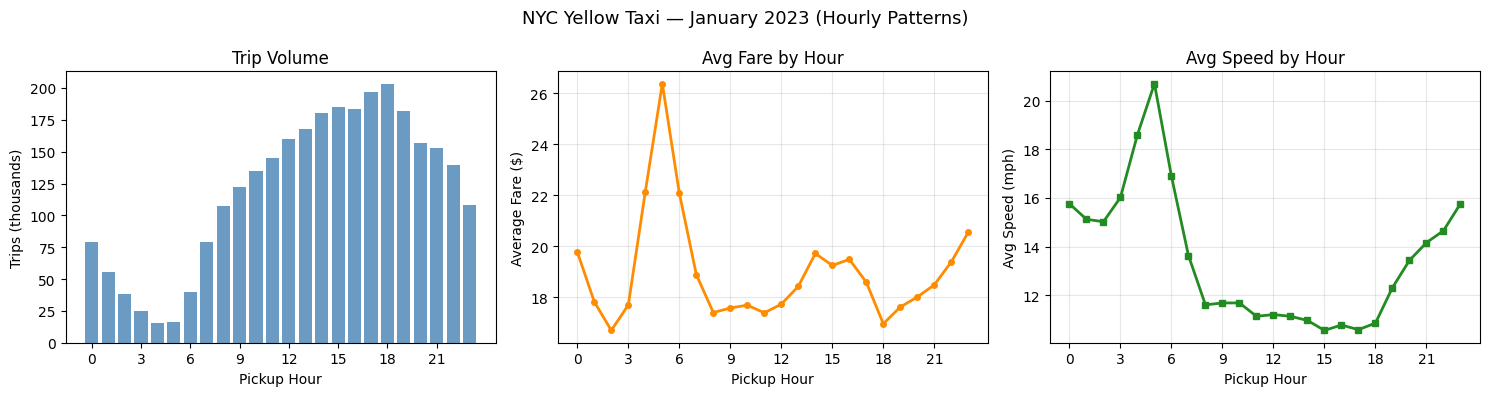

Saved: nyc_taxi_hourly.png


In [12]:
# --- VISUALIZE ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("NYC Yellow Taxi — January 2023 (Hourly Patterns)", fontsize=13)

hours = hourly_summary["pickup_hour"]

# Panel 1: Trips by hour
axes[0].bar(hours, hourly_summary["trip_count"] / 1000, color="steelblue", alpha=0.8)
axes[0].set_xlabel("Pickup Hour")
axes[0].set_ylabel("Trips (thousands)")
axes[0].set_title("Trip Volume")
axes[0].set_xticks(range(0, 24, 3))

# Panel 2: Average fare by hour
axes[1].plot(hours, hourly_summary["avg_fare"], color="darkorange",
             marker="o", markersize=4, linewidth=2)
axes[1].set_xlabel("Pickup Hour")
axes[1].set_ylabel("Average Fare ($)")
axes[1].set_title("Avg Fare by Hour")
axes[1].set_xticks(range(0, 24, 3))
axes[1].grid(True, alpha=0.3)

# Panel 3: Average speed by hour
axes[2].plot(hours, hourly_summary["avg_speed"], color="forestgreen",
             marker="s", markersize=4, linewidth=2)
axes[2].set_xlabel("Pickup Hour")
axes[2].set_ylabel("Avg Speed (mph)")
axes[2].set_title("Avg Speed by Hour")
axes[2].set_xticks(range(0, 24, 3))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("nyc_taxi_hourly.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved: nyc_taxi_hourly.png")

---
## Section 7 — Performance Comparison: Ray Data vs. Serial Pandas

We process 3 months of NYC Taxi data (Jan–Mar 2023) in two ways:
1. **Serial pandas** — read each Parquet file sequentially with PyArrow, apply the same transforms
2. **Ray Data** — read all 3 files in parallel with `read_parquet`, apply the same `map_batches` pipeline

### Why the speedup may be modest on t3.large

- **Only 2 CPUs** — parallelism is limited
- **S3 network I/O** is often the bottleneck, not CPU
- On a `c5.18xlarge` (72 CPUs) or a 5-node cluster, expect 5–15× speedup for CPU-bound transforms

In [15]:
# The three Parquet files we'll process
MONTHS = ["2023-01", "2023-02", "2023-03"]
PARQUET_PATHS = [
    f"{YOUR_BUCKET_NAME}/nyt/yellow_tripdata_{m}.parquet"
    for m in MONTHS
]
s3_anon = pafs.S3FileSystem(region="us-east-1")

# --- Serial pandas baseline ---
def process_month_pandas(path: str, fs) -> pd.DataFrame:
    """Read and transform one month of taxi data using pandas."""
    table = pq.read_table(path, filesystem=fs)
    df = table.to_pandas()
    df = clean_taxi_batch(df)
    df = engineer_features_batch(df)
    return df

print("Running serial pandas baseline (3 months)...")
t_serial_start = time.time()

serial_dfs = []
for path in PARQUET_PATHS:
    print(f"  Reading {path.split('/')[-1]}...", end="", flush=True)
    t0 = time.time()
    df = process_month_pandas(path, s3_anon)
    serial_dfs.append(df)
    print(f" {len(df):,} rows in {time.time()-t0:.1f}s")

serial_total = pd.concat(serial_dfs, ignore_index=True)
t_serial = time.time() - t_serial_start

print(f"\nSerial total: {len(serial_total):,} rows in {t_serial:.1f}s")

Running serial pandas baseline (3 months)...
  Reading yellow_tripdata_2023-01.parquet...

/tmp/ipykernel_14946/641366733.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
/tmp/ipykernel_14946/641366733.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pickup_dow"] = df["tpep_pickup_datetime"].dt.dayofweek  # 0=Mon, 6=Sun
/tmp/ipykernel_14946/641366733.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

 2,872,860 rows in 14.3s
  Reading yellow_tripdata_2023-02.parquet...

/tmp/ipykernel_14946/641366733.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["avg_speed_mph"] = df["avg_speed_mph"].clip(0, 100)
/tmp/ipykernel_14946/641366733.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
/tmp/ipykernel_14946/641366733.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

 2,721,859 rows in 9.7s
  Reading yellow_tripdata_2023-03.parquet...

: 

In [6]:
# --- Ray Data parallel ---
print("Running Ray Data parallel (3 months)...")
# The three Parquet files we'll process
MONTHS = ["2023-01", "2023-02", "2023-03"]
PARQUET_PATHS = [
    f"{YOUR_BUCKET_NAME}/nyt/yellow_tripdata_{m}.parquet"
    for m in MONTHS
]
s3_anon = pafs.S3FileSystem(region="us-east-1")

t_ray_start = time.time()

ray_ds = ray.data.read_parquet(PARQUET_PATHS, filesystem=s3_anon)
ray_ds = ray_ds.map_batches(clean_taxi_batch, batch_format="pandas")
ray_ds = ray_ds.map_batches(engineer_features_batch, batch_format="pandas")

ray_total = ray_ds.to_pandas()
t_ray = time.time() - t_ray_start

print(f"Ray Data total: {len(ray_total):,} rows in {t_ray:.1f}s")
print(f"\nSpeedup: {t_serial / t_ray:.2f}x")

Running Ray Data parallel (3 months)...


2026-02-19 21:10:00,474	WARNING tqdm_ray.py:319 -- tqdm is not installed. Progress bars will be disabled.
2026-02-19 21:10:04,544	INFO parquet_datasource.py:1079 -- Estimated parquet encoding ratio is 9.255.
2026-02-19 21:10:04,546	INFO parquet_datasource.py:1139 -- Estimated parquet reader batch size at 907540 rows


NameError: name 'clean_taxi_batch' is not defined

In [ ]:
# Timing comparison chart
fig, ax = plt.subplots(figsize=(7, 4))

methods = ["Serial\n(pandas)", f"Ray Data\n(parallel)"]
times = [t_serial, t_ray]
colors = ["#d62728", "#1f77b4"]

bars = ax.bar(methods, times, color=colors, alpha=0.85, width=0.5)

for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            f"{t:.1f}s", ha="center", va="bottom", fontsize=12, fontweight="bold")

speedup = t_serial / t_ray
ax.set_ylabel("Wall-clock time (seconds)", fontsize=11)
ax.set_title(
    f"Ray Data vs. Serial pandas — 3 months NYC Taxi\n"
    f"({speedup:.2f}× speedup on t3.large, 2 CPUs)",
    fontsize=11
)
ax.set_ylim(0, max(times) * 1.25)
ax.grid(axis="y", alpha=0.3)

# Annotation explaining the modest speedup
ax.text(0.98, 0.95,
        f"t3.large: 2 CPUs\nS3 I/O often limits speedup\nExpect 5–15× on c5.18xlarge",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=9, color="gray",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
plt.savefig("ray_vs_pandas_timing.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved: ray_vs_pandas_timing.png")

### Why the speedup matters at scale

On a **t3.large** (2 CPUs), Ray's overhead often competes with the parallelism benefit for S3-bound workloads. The real payoff comes when:

| Scenario | Expected speedup |
|----------|----------------|
| t3.large, 2 CPUs, S3 I/O bound | 1–2× |
| c5.4xlarge, 16 CPUs, CPU-bound transforms | 4–10× |
| 5-node cluster (t3.large × 5), 10 CPUs total | 3–8× |
| c5.18xlarge, 72 CPUs, pure CPU transforms | 15–30× |

The transform functions (`clean_taxi_batch`, `engineer_features_batch`) are CPU-bound. On a bigger machine or cluster, each additional CPU linearly reduces wall time — up to S3 bandwidth limits.

---
## Section 8 — Multi-Node Cluster Reference

### Why go multi-node?

- **More CPUs** → more parallelism in `map_batches`
- **More RAM** → larger datasets without spilling to disk
- **Distributed Object Store** → each node has its own store; Ray routes data automatically

**Cost estimate** (AWS `us-east-1`, on-demand):

| Configuration | CPUs | Cost/hr |
|---------------|------|--------|
| 1× t3.large (current) | 2 | $0.083 |
| 3× t3.large cluster | 6 | $0.25 |
| 5× t3.large cluster | 10 | $0.42 |

> **AWS Academy note**: Multi-node clusters can burn through credits quickly. Always run `ray down` when finished, then stop your EC2 instance.

In [ ]:
# REFERENCE ONLY — do NOT execute this cell; it is shown for illustration
# This YAML would be saved as ray-cluster.yaml and used with `ray up`

RAY_CLUSTER_YAML = """
# ray-cluster.yaml — 1 head + 4 workers (5 × t3.large)
cluster_name: dats6450-ray

provider:
  type: aws
  region: us-east-1
  availability_zone: us-east-1a

auth:
  ssh_user: ubuntu
  ssh_private_key: ~/.ssh/your-key.pem  # your Lab 3a key pair

head_node_type: ray.head.default
worker_node_types:
  - name: ray.worker.default
    min_workers: 4
    max_workers: 4

available_node_types:
  ray.head.default:
    resources: {}
    node_config:
      InstanceType: t3.large
      ImageId: ami-0c55b159cbfafe1f0  # Ubuntu 22.04 us-east-1
      IamInstanceProfile:
        Name: LabInstanceProfile
      SecurityGroupIds:
        - sg-XXXXXXXX  # your Lab 3a security group

  ray.worker.default:
    resources: {}
    node_config:
      InstanceType: t3.large
      ImageId: ami-0c55b159cbfafe1f0
      IamInstanceProfile:
        Name: LabInstanceProfile
      SecurityGroupIds:
        - sg-XXXXXXXX

setup_commands:
  - pip install -U "ray[data,serve,tune]>=2.54.0" pyarrow boto3

head_setup_commands:
  - pip install jupyter
"""

print(RAY_CLUSTER_YAML)

### Cluster lifecycle commands

> **REFERENCE ONLY** — do not run these in this notebook. They would be run in a terminal.

```bash
# 1. Start the cluster (provisions EC2 instances + installs Ray)
ray up ray-cluster.yaml

# 2. Check cluster status
ray status

# 3. Submit a job to the cluster
ray job submit --working-dir . \
  --address ray://HEAD_IP:10001 \
  -- python my_ray_script.py

# 4. Port-forward the dashboard
ray dashboard ray-cluster.yaml
# Then open http://localhost:8265

# 5. IMPORTANT: Tear down cluster when done to stop billing!
ray down ray-cluster.yaml

# 6. Connect an existing script to the cluster
# Inside the script:
#   ray.init(address="ray://HEAD_IP:10001")
```

When connecting with `ray.init(address="ray://HEAD_IP:10001")`, your `@ray.remote` tasks and actors automatically distribute across all 5 nodes. No other code changes needed!

---
## Section 9 — Cleanup & Summary

In [9]:
# Shut down Ray
ray.shutdown()
print("Ray shut down.")

# List files written to S3
print(f"\nFiles written to s3://{YOUR_BUCKET_NAME}/ray-tutorial/")
try:
    s3_client = boto3.client("s3")
    response = s3_client.list_objects_v2(
        Bucket=YOUR_BUCKET_NAME,
        Prefix="ray-tutorial/",
    )
    if "Contents" in response:
        for obj in response["Contents"]:
            size_kb = obj["Size"] / 1024
            print(f"  {obj['Key']:60s} {size_kb:8.1f} KB")
    else:
        print("  (no files found — check YOUR_BUCKET_NAME)")
except Exception as e:
    print(f"  Could not list S3 files: {e}")

# List local files
import os
local_files = ["nyc_taxi_hourly.png", "ray_vs_pandas_timing.png"]
print("\nLocal files created:")
for f in local_files:
    if os.path.exists(f):
        size_kb = os.path.getsize(f) / 1024
        print(f"  {f:40s} {size_kb:.1f} KB")
    else:
        print(f"  {f:40s} (not found — did Section 6/7 complete?)")

Ray shut down.

Files written to s3://adg-gwustudent-s2026/ray-tutorial/
  (no files found — check YOUR_BUCKET_NAME)

Local files created:
  nyc_taxi_hourly.png                      (not found — did Section 6/7 complete?)
  ray_vs_pandas_timing.png                 (not found — did Section 6/7 complete?)


## Summary

| Concept | What it is | When to use it |
|---------|-----------|----------------|
| **Ray Task** | `@ray.remote` function → called with `.remote()` | Stateless parallel work (batch transforms, I/O) |
| **Ray Actor** | `@ray.remote` class → stateful worker process | Counters, caches, ML model servers |
| **Object Store** | `ray.put()` / `ray.get()` — shared memory | Large reference data shared across many tasks |
| **Ray Data** | Distributed dataset with lazy `map_batches` | ETL pipelines, ML preprocessing at scale |
| **Multi-node** | `ray up` cluster YAML + `ray.init(address=...)` | Production workloads needing >2 CPUs or >8 GB RAM |

### Next steps

- **Ray Train** — distributed ML training (PyTorch, XGBoost)
- **Ray Tune** — hyperparameter optimization at scale
- **Ray Serve** — model serving with autoscaling
- [Ray documentation](https://docs.ray.io/en/latest/) | [NYC Taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)